##  ANALYSIS ON TMDB 5000 Movie Dataset

#### Firstly, I  import some modules and define a few functions to find out some useful information of datasets.

In [1]:
import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.offline as pyo
pyo.init_notebook_mode()
from plotly.graph_objs import *
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.core.interactiveshell import InteractiveShell
from PIL import *
from collections import Counter
from subprocess import check_output

In [2]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

#### Then, I give some information on the columns types and the number of missing values.

In [4]:
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
    
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

#### And I define a few other functions to create an interface with the new structure of the dataset.

In [5]:
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [6]:
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()

#### I connect these two csv datasets together.

In [7]:
credits = load_tmdb_credits("./tmdb_5000_credits.csv")
movies = load_tmdb_movies("./tmdb_5000_movies.csv")
df = convert_to_original_format(movies, credits)
print('Shape:',df.shape)


Shape: (4803, 26)


#### And I list all the information of movies in order to figure out differences among movies.

In [8]:
data=pd.DataFrame(df)
data.head()[:5]

budget                                    genres  \
0  237000000  Action|Adventure|Fantasy|Science Fiction   
1  300000000                  Adventure|Fantasy|Action   
2  245000000                    Action|Adventure|Crime   
3  250000000               Action|Crime|Drama|Thriller   
4  260000000          Action|Adventure|Science Fiction   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                       plot_keywords  language  \
0  culture clash|future|space war|space colony|so...   English   
1  ocean|drug abuse|exotic island|east india trad...   English   
2  spy|based on novel|secret agent|sequel|mi6|bri...  Français   
3  dc comics|crime fighter|terrorist|secret ident...   English   
4  based on novel|mars|medallion|space travel|pri...   English   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  \
0  [{'name': 'Ingenious Film Partners', 'id': 289...   
1  [{'name': 'Walt Disney Pictures', 'id': 2}, {'...   
2  [{'name': 'Columbia Pictures', 'id': 5}, {'nam...   
3  [{'name': 'Legendary Pictures', 'id': 923}, {'...   
4        [{'name': 'Walt Disney Pictures', 'id': 2}]   

                                production_countries release_date       gross  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...   2009-12-10  2787965087   
1  [{'iso_3166_1': 'US', 'name': 'United States o...   2007-05-19   961000000   
2  [{'iso_3166_1': 'GB', 'name': 'United Kingdom'...   2015-10-26   880674609   
3  [{'iso_3166_1': 'US', 'name': 'United States o...   2012-07-16  1084939099   
4  [{'iso_3166_1': 'US', 'name': 'United States o...   2012-03-07   284139100   

   duration                                   spoken_languages    status  \
0     162.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
1     169.0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2     148.0  [{'iso_639_1': 'fr', 'name': 'Français'}, {'is...  Released   
3     165.0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
4     132.0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                movie_title  vote_average  num_voted_users  \
0                                    Avatar           7.2            11800   
1  Pirates of the Caribbean: At World's End           6.9             4500   
2                                   Spectre           6.3             4466   
3                     The Dark Knight Rises           7.6             9106   
4                               John Carter           6.1             2124   

   title_year                   country      director_name     actor_1_name  \
0      2009.0  United States of America      James Cameron      Z

###  1.Keywords
####  I  find out the most popular keywords about movies.   

I first list the keywords which are in the dataset.

In [9]:
set_keywords = set()
for liste_keywords in df['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue
    set_keywords = set_keywords.union(liste_keywords)
set_keywords.remove('')

In [10]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

Then I calculate the number of occurences of the most five popular keywords from datasets.

In [11]:
keyword_occurences, dum = count_word(df, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

As showing above,the occurences of keywords are in huge difference.

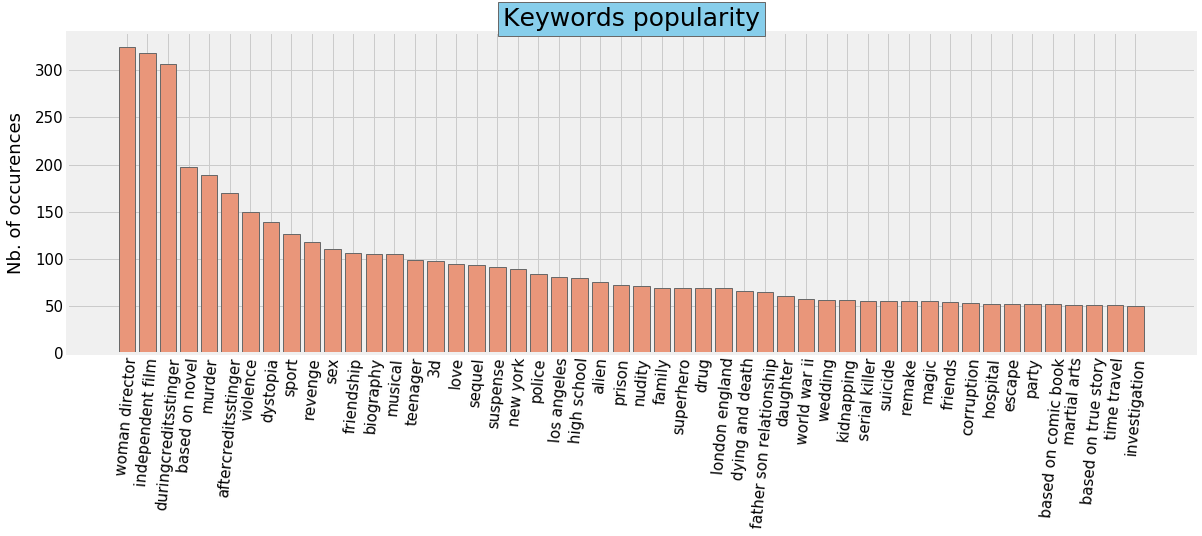

In [12]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(20, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

fig = plt.figure(1, figsize=(18,13))

words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 

ax1 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax1.bar(x_axis, y_axis, align = 'center', color='darksalmon')

plt.title("Keywords popularity",bbox={'facecolor':'skyblue', 'pad':5},color='black',fontsize = 25)
plt.show()

This bar graph shows clearly different occurences of pipular keywords.

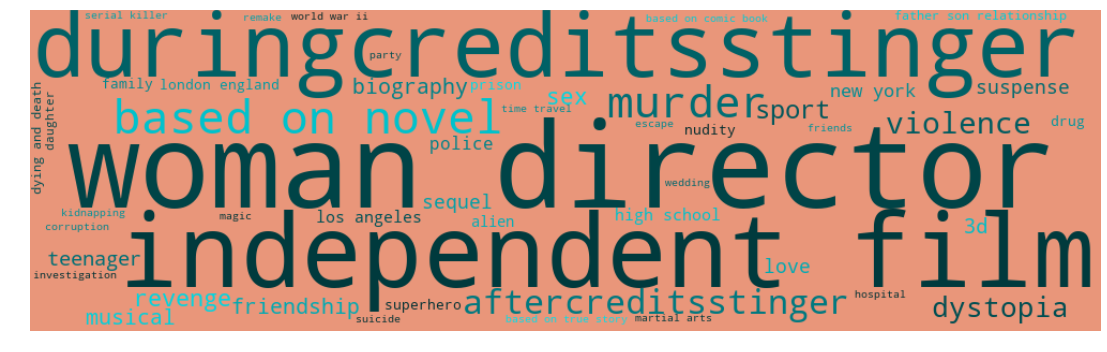

In [13]:

fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,1)

words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 130.0 
wordcloud = WordCloud(width=1000,height=300, background_color='darksalmon', 
                      max_words=5000,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax2.imshow(wordcloud, interpolation="bilinear")
ax2.axis('off')
plt.show()

The wordcloud graph shows clearly what are the most popular words than bar graph with different sizes of figures.

### 2. Genres

#### I want to find out different types of movies.

There are many kinds of movies in these datasets.I first list and count the most popular genres of movies

In [14]:
genre_labels = set()
for s in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

keyword_occurences, dum = count_word(df, 'genres', genre_labels)
keyword_occurences[:50]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894],
 ['Adventure', 790],
 ['Crime', 696],
 ['Science Fiction', 535],
 ['Horror', 519],
 ['Family', 513],
 ['Fantasy', 424],
 ['Mystery', 348],
 ['Animation', 234],
 ['History', 197],
 ['Music', 185],
 ['War', 144],
 ['Documentary', 110],
 ['Western', 82],
 ['Foreign', 34],
 ['', 28],
 ['TV Movie', 8]]

Next, I choose the wordcloud to show the popularity of different types of movies. 

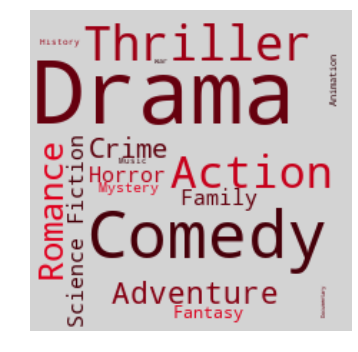

In [15]:
from os import path
d='' 
alice_coloring = np.array(Image.open(path.join(d, "aaa.png")))
image_colors = ImageColorGenerator(alice_coloring)

fig = plt.figure(1, figsize=(18,13))
ax3 = fig.add_subplot(2,1,1)
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 250.0 
wordcloud = WordCloud(mask=alice_coloring, background_color='lightgrey', 
                      max_words=5000,relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax3.imshow(wordcloud, interpolation="bilinear")
ax3.axis('off')
plt.show()

It  is not the best way to show what kind of movies is the most popular movies,so I change the type of analysis graph to pie graph. 

In [16]:
liste_genres = set()
for s in df['genres'].str.split('|'):
    liste_genres = set().union(s, liste_genres)
liste_genres = list(liste_genres)
liste_genres.remove('')

In [17]:
df_reduced = df[['actor_1_name', 'vote_average',
                 'title_year', 'movie_title']].reset_index(drop = True)
for genre in liste_genres:
    df_reduced[genre] = df['genres'].str.contains(genre).apply(lambda x:1 if x else 0)
df_reduced[:5]

actor_1_name  vote_average  title_year  \
0      Zoe Saldana           7.2      2009.0   
1    Orlando Bloom           6.9      2007.0   
2  Christoph Waltz           6.3      2015.0   
3    Michael Caine           7.6      2012.0   
4     Lynn Collins           6.1      2012.0   

                                movie_title  Adventure  Documentary  \
0                                    Avatar          1            0   
1  Pirates of the Caribbean: At World's End          1            0   
2                                   Spectre          1            0   
3                     The Dark Knight Rises          0            0   
4                               John Carter          1            0   

   Science Fiction  War  Romance  Thriller  Family  Comedy  Drama  Animation  \
0                1    0        0         0       0       0      0          0   
1                0    0        0         0       0       0      0          0   
2                0    0        0         0       0       0      0          0   
3                0    0        0         1       0       0      1          0   
4                1    0        0         0       0       0      0          0   

   Mystery  Foreign  Fantasy  Western  History  Crime  Action  Music  \
0        0        0        1        0        0      0       1      0   
1        0        0        1        0        0      0       1      0   
2        0        0        0        0        0      1       1      0   
3        0        0        0        0        0      1       1      0   
4        0        0        0        0        0      0       1      0   

   TV Movie  Horror  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0

In [18]:
df_actors = df_reduced.groupby('actor_1_name').mean()
df_actors.loc[:, 'favored_genre'] = df_actors[liste_genres].idxmax(axis = 1)
df_actors.drop(liste_genres, axis = 1, inplace = True)
df_actors = df_actors.reset_index()
df_actors[:10]

actor_1_name  vote_average   title_year favored_genre
0       A.J. Buckley      5.000000  2010.000000        Family
1          A.J. Cook      5.900000  2003.000000       Mystery
2            Aaliyah      5.700000  2001.000000      Thriller
3       Aaran Thomas      6.000000  2007.000000      Thriller
4      Aaron Eckhart      6.066667  2006.555556      Thriller
5        Aaron Ruell      6.700000  2004.000000        Comedy
6      Abbey Lincoln      7.000000  1964.000000         Drama
7      Abbie Cornish      6.166667  2009.666667       Fantasy
8  Abhishek Bachchan      6.600000  2009.000000        Family
9    Abigail Breslin      6.166667  2012.000000       Romance

In [19]:
df_appearance = df_reduced[['actor_1_name', 'title_year']].groupby('actor_1_name').count()
df_appearance = df_appearance.reset_index(drop = True)
selection = df_appearance['title_year'] > 4
selection = selection.reset_index(drop = True)
most_prolific = df_actors[selection]

In [20]:
colors = ['palevioletred', 'tomato', 'darkgrey', 'pink', 'hotpink', 'darksalmon', 'lightpink',
          'lightcoral', 'salmon', 'lightpink', 'grey', 'lightgrey', 'indianred', 'ivory']

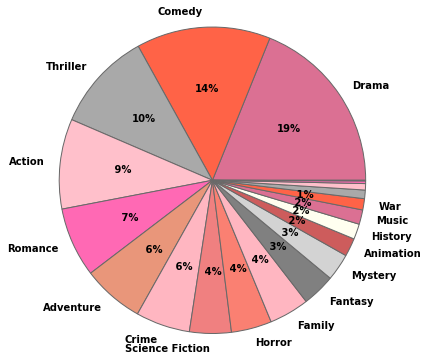

In [21]:
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(5, 5))
genre_count = []
for genre in liste_genres:
    genre_count.append([genre, df_reduced[genre].values.sum()])
genre_count.sort(key = lambda x:x[1], reverse = True)
labels, sizes = zip(*genre_count)
labels_selected = [n if v > sum(sizes) * 0.01 else '' for n, v in genre_count]
ax.pie(sizes, colors=colors,labels=labels_selected,
       autopct = lambda x:'{:2.0f}%'.format(x) if x > 1 else '',
       shadow=False,startangle=0)
ax.axis('equal')
plt.tight_layout()

The graph shows clearly that drama comedy and thriller are the most popular types of movies.

###  3.Actors
#### Then, I want to analyze all the actors appeared in more than five movies to find out some common features of most outstanding actors.

I first statistics the average votes every year about the favorite genres of movies. 

In [22]:
reduced_genre_list = labels[:20]
trace=[]
for genre in reduced_genre_list:
    trace.append({'type':'scatter',
                  'mode':'markers',
                  'y':most_prolific.loc[most_prolific['favored_genre']==genre,'vote_average'],
                  'x':most_prolific.loc[most_prolific['favored_genre']==genre,'title_year'],
                  'name':genre,
                  'text': most_prolific.loc[most_prolific['favored_genre']==genre,'actor_1_name'],
                  'marker':{'size':10,'opacity':0.7,
                            'line':{'width':1.25,'color':'black'}}})
layout={'title':'Favored genres',
       'xaxis':{'title':'mean year of activity'},
       'yaxis':{'title':'mean score'}}
fig=Figure(data=trace,layout=layout)
pyo.iplot(fig)

And I want to find out who are the actors appeared in movies more than ten years.

In [24]:
selection = df_appearance['title_year'] > 10
most_prolific = df_actors[selection]
most_prolific

actor_1_name  vote_average   title_year favored_genre
49          Alec Baldwin      6.645455  2005.545455         Drama
275            Brad Pitt      6.833333  2003.583333      Thriller
649         Diane Keaton      6.090909  1997.454545        Comedy
1174    Jennifer Aniston      6.226667  2006.600000        Comedy
1908      Morgan Freeman      6.469231  2002.769231         Crime
2218      Robert De Niro      6.145455  1999.727273        Comedy
2303   Samuel L. Jackson      6.425000  2002.000000      Thriller
2327  Scarlett Johansson      6.472727  2007.000000         Drama

It shows above that there are eight famous actors. And I choose Alec Baldwin, Scarlett Johansson and Samuel L. Jacksonas examples of these actors to analyze.
Firstly, I find out the types of movies that they played most.

In [25]:
class Trace():
    def __init__(self, color):
        self.mode = 'markers'
        self.name = 'default'
        self.title = 'default title'
        self.marker = dict(color=color, size=110,
                           line=dict(color='white'), opacity=0.7)
        self.r = []
        self.t = []
    #______________________________
    def set_color(self, color):
        self.marker = dict(color = color, size=110,
                           line=dict(color='white'), opacity=0.7)
    #____________________________
    def set_name(self, name):
        self.name = name
    #____________________________
    def set_title(self, title):
        self.na = title
    #__________________________
    def set_values(self, r, t):
        self.r = np.array(r)
        self.t = np.array(t)

In [26]:
df2 = df_reduced[df_reduced['actor_1_name'] == 'Alec Baldwin']
total_count  = 0
years = []
imdb_score = []
genre = []
titles = []
for s in liste_genres:
    icount = df2[s].sum()
    if icount > 3: 
        total_count += 1
        genre.append(s)
        years.append(list(df2[df2[s] == 1]['title_year']))
        imdb_score.append(list(df2[df2[s] == 1]['vote_average'])) 
        titles.append(list(df2[df2[s] == 1]['movie_title']))
max_y = max([max(s) for s in years])
min_y = min([min(s) for s in years])
year_range = max_y - min_y
years_normed = []
for i in range(total_count):
    years_normed.append( [360/total_count*((an-min_y)/year_range+i) for an in years[i]])

In [27]:
trace = [Trace(colors[i]) for i in range(total_count)]
tr    = []
for i in range(total_count):
    trace[i].set_name(genre[i])
    trace[i].set_title(titles[i])
    trace[i].set_values(np.array(imdb_score[i]),
                        np.array(years_normed[i]))
    tr.append(go.Scatter(r      = trace[i].r,
                         t      = trace[i].t,
                         mode   = trace[i].mode,
                         name   = trace[i].name,
                         marker = trace[i].marker,
                         hoverinfo = 'all'
                        ))        
layout = go.Layout(
    title='Alec Baldwin movies',
    font=dict(
        size=15
    ),
    plot_bgcolor='rgb(223, 223, 223)',
    angularaxis=dict(        
        tickcolor='rgb(253,253,253)'
    ),
    hovermode='Closest',
)
fig = go.Figure(data = tr, layout=layout)
pyo.iplot(fig)

In [28]:
df3 = df_reduced[df_reduced['actor_1_name'] == 'Scarlett Johansson']
total_count  = 0
years = []
imdb_score = []
genre = []
titles = []
for s in liste_genres:
    icount = df3[s].sum()
    if icount > 3: 
        total_count += 1
        genre.append(s)
        years.append(list(df3[df3[s] == 1]['title_year']))
        imdb_score.append(list(df3[df3[s] == 1]['vote_average'])) 
        titles.append(list(df3[df3[s] == 1]['movie_title']))
max_y = max([max(s) for s in years])
min_y = min([min(s) for s in years])
year_range = max_y - min_y
years_normed = []
for i in range(total_count):
    years_normed.append( [360/total_count*((an-min_y)/year_range+i) for an in years[i]])

In [29]:
trace = [Trace(colors[i]) for i in range(total_count)]
tr    = []
for i in range(total_count):
    trace[i].set_name(genre[i])
    trace[i].set_title(titles[i])
    trace[i].set_values(np.array(imdb_score[i]),
                        np.array(years_normed[i]))
    tr.append(go.Scatter(r      = trace[i].r,
                         t      = trace[i].t,
                         mode   = trace[i].mode,
                         name   = trace[i].name,
                         marker = trace[i].marker,
                         hoverinfo = 'all'
                        ))        
layout = go.Layout(
    title='Scarlett Johansson movies',
    font=dict(
        size=15
    ),
    plot_bgcolor='rgb(223, 223, 223)',
    angularaxis=dict(        
        tickcolor='rgb(253,253,253)'
    ),
    hovermode='Closest',
)
fig = go.Figure(data = tr, layout=layout)
pyo.iplot(fig)

In [30]:
df4 = df_reduced[df_reduced['actor_1_name'] == 'Samuel L. Jackson']
total_count  = 0
years = []
imdb_score = []
genre = []
titles = []
for s in liste_genres:
    icount = df4[s].sum()
    if icount > 3: 
        total_count += 1
        genre.append(s)
        years.append(list(df4[df4[s] == 1]['title_year']))
        imdb_score.append(list(df4[df4[s] == 1]['vote_average'])) 
        titles.append(list(df4[df4[s] == 1]['movie_title']))
max_y = max([max(s) for s in years])
min_y = min([min(s) for s in years])
year_range = max_y - min_y
years_normed = []
for i in range(total_count):
    years_normed.append( [360/total_count*((an-min_y)/year_range+i) for an in years[i]])

In [31]:
trace = [Trace(colors[i]) for i in range(total_count)]
tr    = []
for i in range(total_count):
    trace[i].set_name(genre[i])
    trace[i].set_title(titles[i])
    trace[i].set_values(np.array(imdb_score[i]),
                        np.array(years_normed[i]))
    tr.append(go.Scatter(r      = trace[i].r,
                         t      = trace[i].t,
                         mode   = trace[i].mode,
                         name   = trace[i].name,
                         marker = trace[i].marker,
                         hoverinfo = 'all'
                        ))        
layout = go.Layout(
    title='Samuel L. Jackson movies',
    font=dict(
        size=15
    ),
    plot_bgcolor='rgb(223, 223, 223)',
    angularaxis=dict(        
        tickcolor='rgb(253,253,253)'
    ),
    hovermode='Closest',
)
fig = go.Figure(data = tr, layout=layout)
pyo.iplot(fig)

These three actors statistics show that comedy and drama are two types of movies of popular actors.

And I try to analyze the connections among popular actors.

In [32]:
selection = df_appearance['title_year'] > 5
most_prolific = df_actors[selection]
actors_list = most_prolific['actor_1_name'].unique()

In [33]:
test = pd.crosstab(df['actor_1_name'], df['actor_2_name'])

In [34]:
edge = []
for actor_1, actor_2 in list(test[test > 0].stack().index):
    if actor_1 not in actors_list: continue
    if actor_2 not in actors_list: continue
   
    if actor_1 not in actors_list or actor_2 not in actors_list: continue
    if actor_1 != actor_2:
        edge.append([actor_1, actor_2])

num_of_adjacencies = [0 for _ in range(len(df_actors))]
for ind, col in df_actors.iterrows():
    actor = col['actor_1_name']
    nb = sum([1 for i,j in edge if (i == actor) or (j == actor)])
    num_of_adjacencies[ind] = nb
    

In [35]:
def prep(edge, num_of_adjacencies, df, actors_list):
    edge_trace = Scatter(
    x=[],
    y=[],
    line = Line(width=0.5,color='grey'),
    hoverinfo = 'none',
    mode = 'lines')

    for actor_1, actor_2 in edge:
        x0, y0 = df[df['actor_1_name'] == actor_1][['title_year', 'vote_average']].unstack()
        x1, y1 = df[df['actor_1_name'] == actor_2][['title_year', 'vote_average']].unstack()
        edge_trace['x'] += [x0, x1, None]
        edge_trace['y'] += [y0, y1, None]

    node_trace = Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=Marker(
            showscale=True,
            reversescale=True,
            color=['palevioletred', 'darkgrey', 'pink', 'hotpink', 'darksalmon', 'lightpink',
          'lightcoral', 'salmon', 'lightpink', 'grey', 'lightgrey','indianred', 'ivory'],
            size=10,
             colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)))

   
    for ind, col in df.iterrows():
        if col['actor_1_name'] not in actors_list: continue
        node_trace['x'].append(col['title_year'])
        node_trace['y'].append(col['vote_average'])
        node_trace['text'].append(col['actor_1_name'])
        node_trace['marker']['color'].append(num_of_adjacencies[ind])
        
  
  

    fig = Figure(data=Data([edge_trace, node_trace]),
                 layout=Layout(
                    title='<br>Connections between actors',
                    titlefont=dict(size=16),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=XAxis(showgrid=True, zeroline=False, showticklabels=True),
                    yaxis=YAxis(showgrid=True, zeroline=False, showticklabels=True)))
    
    return fig

In [36]:
fig = prep(edge, num_of_adjacencies, df_actors, actors_list)
pyo.iplot(fig)

It shows that popular actors are connecting with each other.

And I try to find out the relationship between actors and earning.

In [37]:
df.head()

budget                                    genres  \
0  237000000  Action|Adventure|Fantasy|Science Fiction   
1  300000000                  Adventure|Fantasy|Action   
2  245000000                    Action|Adventure|Crime   
3  250000000               Action|Crime|Drama|Thriller   
4  260000000          Action|Adventure|Science Fiction   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                       plot_keywords  language  \
0  culture clash|future|space war|space colony|so...   English   
1  ocean|drug abuse|exotic island|east india trad...   English   
2  spy|based on novel|secret agent|sequel|mi6|bri...  Français   
3  dc comics|crime fighter|terrorist|secret ident...   English   
4  based on novel|mars|medallion|space travel|pri...   English   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  \
0  [{'name': 'Ingenious Film Partners', 'id': 289...   
1  [{'name': 'Walt Disney Pictures', 'id': 2}, {'...   
2  [{'name': 'Columbia Pictures', 'id': 5}, {'nam...   
3  [{'name': 'Legendary Pictures', 'id': 923}, {'...   
4        [{'name': 'Walt Disney Pictures', 'id': 2}]   

                                production_countries release_date       gross  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...   2009-12-10  2787965087   
1  [{'iso_3166_1': 'US', 'name': 'United States o...   2007-05-19   961000000   
2  [{'iso_3166_1': 'GB', 'name': 'United Kingdom'...   2015-10-26   880674609   
3  [{'iso_3166_1': 'US', 'name': 'United States o...   2012-07-16  1084939099   
4  [{'iso_3166_1': 'US', 'name': 'United States o...   2012-03-07   284139100   

   duration                                   spoken_languages    status  \
0     162.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
1     169.0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2     148.0  [{'iso_639_1': 'fr', 'name': 'Français'}, {'is...  Released   
3     165.0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
4     132.0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                movie_title  vote_average  num_voted_users  \
0                                    Avatar           7.2            11800   
1  Pirates of the Caribbean: At World's End           6.9             4500   
2                                   Spectre           6.3             4466   
3                     The Dark Knight Rises           7.6             9106   
4                               John Carter           6.1             2124   

   title_year                   country      director_name     actor_1_name  \
0      2009.0  United States of America      James Cameron      Z

Text(28.58,0.5,'Year')

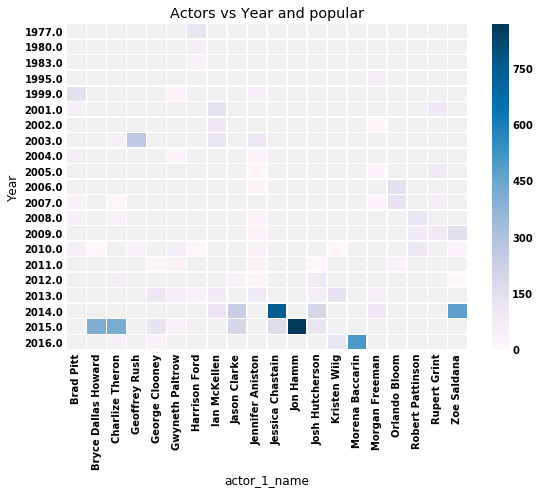

In [38]:
df['popular'] = df['popularity'] - df['vote_average']
df_copy = df.copy().dropna()
director_budge = df_copy.groupby(df_copy['actor_1_name'])['popular'].sum()
direcotr_budge_indx = director_budge.sort_values(ascending=False)[:20].index
director_budge_pivot = pd.pivot_table(data = df_copy[df_copy['actor_1_name'].isin(direcotr_budge_indx)],
                                      index=['title_year'],
                                      columns=['actor_1_name'],
                                      values=['popular'],
                                      aggfunc='sum')
  
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(director_budge_pivot['popular'],vmin=0,annot=False,linewidth=.5,ax=ax,cmap='PuBu',)

plt.title('Actors vs Year and popular')
plt.ylabel('Year')

This graph is not very useful for analyzing actors because there is just an popular actors shown above.

### 4. Conclusion
#### The most popular actors may play comedy, drama and romance more than other genres of movies and they have good connections with others.
#### I analyze keywords but it useless,and I analyze genres and actors to find out the common features of the most popular actors. And the potential connections of actors and popularity is no contributions about what I want to find out.

